# Problem Description

In the post-pandemic scenario, as cinemas across the US open again, a large cinema property owner MMC Sercado wants to detect humans who are wearing face masks correctly, incorrectly and not wearing at all.

Build a Transfer Learning model to detect face masks on humans.

## Dataset Description

The zip folder contains 2 folders train and test each folder with 3 subfolders labelled as to which class they belong to.

The 3 classes are
- "with_mask"
- "without_mask"
- "mask_worn_incorrect"

Each image is of shape 128,128,3.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gc
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
#from keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.optimizers import Adam

## **Task A**

#### 1. Load the Image Training and Test Datasets from the train and test folder respectively. Each image is of shape 128 x 128 x 3

In [ ]:
# Doesn't work
# !unzip -q face_mask_detection.zip

In [ ]:
import zipfile

# File name must match
with zipfile.ZipFile('face_mask_detection_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
train_data_generator = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True, vertical_flip = True, zoom_range = 0.1,
    shear_range = 0.1, width_shift_range = 0.2, height_shift_range = 0.2, rotation_range = 90,
)
test_data_generator = keras.preprocessing.image.ImageDataGenerator()

#### 2. Load training dataset using Keras ImageDataGenerator

In [ ]:
train_data = train_data_generator.flow_from_directory("./face_mask_detection_dataset/train", target_size = (128, 128), batch_size = 1, shuffle = True)


Found 8082 images belonging to 3 classes.


#### 3. Load test dataset using Keras ImageDataGenerator

In [ ]:
test_data = test_data_generator.flow_from_directory("./face_mask_detection_dataset/test", target_size = (128,128), batch_size = 1, shuffle = True)

Found 900 images belonging to 3 classes.


In [ ]:
labels = train_data.class_indices
labels

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

There are three labels found 'mask_weared_incorrect', 'with_mask', 'without_mask'

ImageDataGenerator does not really assign values to an array, it just hold pointers. Because of that every learning step CPU perform reading operations. This very slows learning speed. We will store data in numpy array type.

In [ ]:
def get_array_from_datagen(train_generator):
  x=[]
  y=[]
  train_generator.reset()
  for i in range(train_generator.__len__()):
    # a,b=train_generator.next()
    a, b = next(train_generator)
    x.append(a)
    y.append(b)
  x=np.array(x, dtype = np.float32)
  y=np.array(y, dtype = np.float32)
  print(x.shape)
  print(y.shape)
  return x,y

X_train, y_train = get_array_from_datagen(train_data)
X_test, y_test = get_array_from_datagen(test_data)

(8082, 1, 128, 128, 3)
(8082, 1, 3)
(900, 1, 128, 128, 3)
(900, 1, 3)


In [ ]:
X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)
y_train = y_train.reshape(-1, 3)
y_test = y_test.reshape(-1, 3)

In [ ]:
input_shape = (128, 128, 3)
class_num = len(labels)

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### 4. Build a Transfer Learning network using Keras with the following layers

- 4.1. Load EfficientNetB0 as first layers using Keras API.
- 4.2. GLobalAveragePooling2D layer
- 4.3. Dropout(0.2)
- 4.4. Dense layer with 3 neurons and activation softmax


In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
efficientnet_model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

#### 5. Compile the model with adam optimizer, categorical_crossentropy loss and with metrics accuracy.

In [ ]:
efficientnet_model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

#### 6. Train the model for 6 epochs with callbacks Reduce Learning Rate on Plateau and early stopping while monitoring validation loss

In [ ]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 0,
    min_lr = 0.00001
)
early_stopping = keras.callbacks.EarlyStopping(patience=5, verbose=1)

In [ ]:
history = efficientnet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=6,
    callbacks = [learning_rate_reduction, early_stopping]
)

Epoch 1/6
253/253 ━━━━━━━━━━━━━━━━━━━━ 137s 244ms/step - accuracy: 0.8567 - loss: 0.3401 - val_accuracy: 0.9644 - val_loss: 0.1214 - learning_rate: 0.0010
Epoch 2/6
253/253 ━━━━━━━━━━━━━━━━━━━━ 55s 51ms/step - accuracy: 0.9747 - loss: 0.0785 - val_accuracy: 0.9900 - val_loss: 0.0381 - learning_rate: 0.0010
Epoch 3/6
253/253 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9857 - loss: 0.0460 - val_accuracy: 0.9922 - val_loss: 0.0317 - learning_rate: 0.0010
Epoch 4/6
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9858 - loss: 0.0408 - val_accuracy: 0.9933 - val_loss: 0.0331 - learning_rate: 0.0010
Epoch 5/6
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.9906 - loss: 0.0298 - val_accuracy: 0.9811 - val_loss: 0.0670 - learning_rate: 0.0010
Epoch 6/6
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.9881 - loss: 0.0354 - val_accuracy: 0.9589 - val_loss: 0.2391 - learning_rate: 0.0010


#### 7. Plot training and validation accuracy and loss against epochs

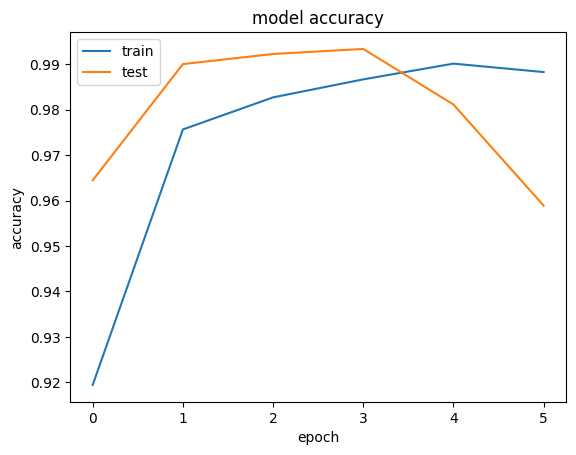

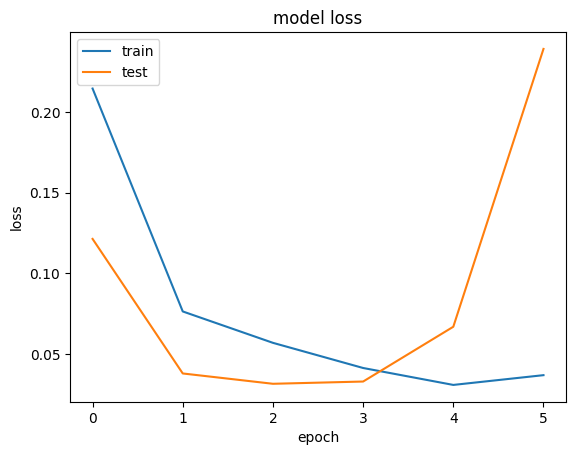

In [ ]:
plot_history(history)

#### Observations

- With this less number of epochs,
  - Train loss decreases continously
  - Training accuracy increases smoothly.
  - Validation loss also decreases continously
  - Validation accuracy also increases smoothly.

## **Task B**

#### 1. Load the Image Training and Test Datasets from the train and test folder respectively. Each image is of shape 128 x 128 x 3
#### 2. Load training dataset using Keras ImageDataGenerator with validation_split=0.2  
#### 3. Load test dataset using Keras ImageDataGenerator


#### 4. Build a Transfer Learning network using Keras with the following layers

- 4.1. Load ResNet50 as first layers using Keras API.
- 4.2. GLobalAveragePooling2D layer
- 4.3. Dropout(0.5)
- 4.4. Dense layer with 3 neurons and activation softmax


In [ ]:
base_model = tf.keras.applications.ResNet50(include_top=False)
resnet_model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#### 5. Compile the model with adam optimizer, categorical_crossentropy loss and with metrics accuracy.

In [ ]:
resnet_model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

#### 6. Train the model for 6 epochs with callbacks Reduce Learning Rate on Plateau and early stopping while monitoring validation loss

In [ ]:
history = resnet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=6,
    callbacks = [learning_rate_reduction, early_stopping]
)

Epoch 1/6
253/253 ━━━━━━━━━━━━━━━━━━━━ 121s 246ms/step - accuracy: 0.7409 - loss: 0.9432 - val_accuracy: 0.6511 - val_loss: 1.1056 - learning_rate: 0.0010
Epoch 2/6
253/253 ━━━━━━━━━━━━━━━━━━━━ 87s 126ms/step - accuracy: 0.8084 - loss: 0.5712 - val_accuracy: 0.4178 - val_loss: 236.8562 - learning_rate: 0.0010
Epoch 3/6
253/253 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.8577 - loss: 0.3856 - val_accuracy: 0.7389 - val_loss: 0.5914 - learning_rate: 0.0010
Epoch 4/6
253/253 ━━━━━━━━━━━━━━━━━━━━ 32s 125ms/step - accuracy: 0.8965 - loss: 0.2913 - val_accuracy: 0.8700 - val_loss: 0.3771 - learning_rate: 0.0010
Epoch 5/6
253/253 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.9260 - loss: 0.2127 - val_accuracy: 0.9267 - val_loss: 0.2303 - learning_rate: 0.0010
Epoch 6/6
253/253 ━━━━━━━━━━━━━━━━━━━━ 42s 128ms/step - accuracy: 0.9522 - loss: 0.1393 - val_accuracy: 0.6178 - val_loss: 1.1829 - learning_rate: 0.0010


#### 7. Plot training and validation accuracy and loss against epochs

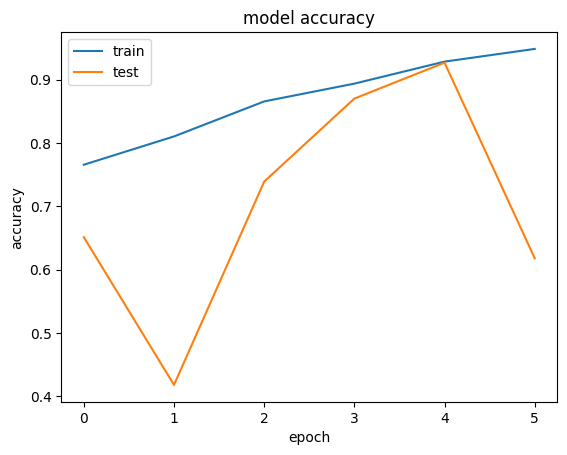

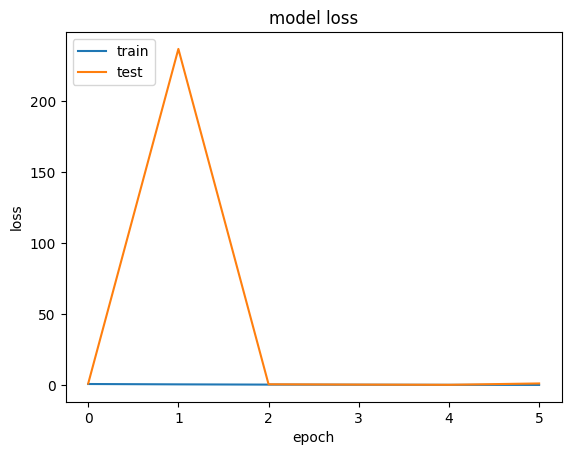

In [ ]:
plot_history(history)

#### Observations

- With this less number of epochs,
  - Train loss decreases continously
  - Training accuracy increases smoothly.
  - Validation loss shows a general trend of decreasing
  - Validation accuracy shows a general trend of increasing

## **Task C**

#### 1. Compare EfficientNetB0 and ResNet50 model performance and find the best model

In [ ]:
test_loss, test_accuracy = efficientnet_model.evaluate(X_test,y_test, batch_size=8)
print(f"EfficientNetB0 Model Performance")
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9587 - loss: 0.1976
EfficientNetB0 Model Performance
Test Loss:     0.23906734585762024
Test Accuracy: 0.9588888883590698


In [ ]:
test_loss, test_accuracy = resnet_model.evaluate(X_test,y_test, batch_size=8)
print(f"ResNet50 Model Performance")
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6100 - loss: 1.1417
ResNet50 Model Performance
Test Loss:     1.182945966720581
Test Accuracy: 0.6177777647972107


Accuracy :

ResNet50 -> 0.8766

EfficientNet -> 0.9933

- The accuracy level of EfficientNet is higher than Resnet50
- The training time of EfficientNet is lesser than Resnet50
- This is because the EfficientNet architecture is smaller than ResNet
- The predicion time of EfficientNet is also lesser than Resnet50
- Because of the EfficientNet model's wider layers architecture helped in achieveing this

Best Model is EfficientNet, we will check recall, precision and f1-score values

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis = 1), efficientnet_model.predict(X_test).argmax(axis = 1)))

29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       300
           1       0.99      0.96      0.97       300
           2       1.00      0.92      0.96       300

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



#### Observations
- Classification report of EfficientNet says that
  - Missclassifications is all the classes are very less
  - mask_weared_incorrect class has got an F1 score of 0.99
  - with_mask class has got an F1 score of 0.99
  - without_mask class has got an F1 score of 1
- There are chances that model get confused with mask_weared_incorrect and with_mask classes

Okay let's look some predictions on validation dataset

Create a small validation set of 25 images

In [ ]:
import os
from shutil import copyfile
os.mkdir("./val_data")
os.mkdir("./val_data/with_mask")
os.mkdir("./val_data/mask_weared_incorrect")
os.mkdir("./val_data/without_mask")

In [ ]:
paths = []
names = []
k = 0
path = "./face_mask_detection_dataset/test/mask_weared_incorrect"
for i in os.listdir(path):
    paths.append(path + "/" + i)
    names.append("mask_weared_incorrect")
    copyfile(path + "/" + i, f"val_data/mask_weared_incorrect/{i}")
    k += 1
    if k == 8:
        break
k = 0
path = "./face_mask_detection_dataset/test/with_mask"
for i in os.listdir(path):
    paths.append(path + "/" + i)
    names.append("with_mask")
    copyfile(path + "/" + i, f"val_data/with_mask/{i}")
    k += 1
    if k == 8:
        break
path = "./face_mask_detection_dataset/test/without_mask"
k = 0
for i in os.listdir(path):
    paths.append(path + "/" + i)
    names.append("without_mask")
    copyfile(path + "/" + i,  f"val_data/without_mask/{i}")
    k += 1
    if k == 9:
        break

In [ ]:
test_data_2 = test_data_generator.flow_from_directory("./val_data", target_size = (128,128), batch_size = 1, shuffle = False)

Found 25 images belonging to 3 classes.


In [ ]:
print(labels)
labels_2 = {}
for k,v in labels.items():
    labels_2[v] = k
labels_2

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}


{0: 'mask_weared_incorrect', 1: 'with_mask', 2: 'without_mask'}

#### 2.Using the best model predict on the dataset and plot 10 images from the test set along with it’s True Label and Predicted Label.

In [ ]:
predictions = efficientnet_model.predict(test_data_2).argmax(axis = 1)
pred_label = []
for i in predictions:
    pred_label.append(labels_2[i])
pred_label

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


['mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask']

In [ ]:
import os
fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(paths[i]))
    ax.set_title(f"PREDICTION:{pred_label[i]}")
    ax.set_xlabel(f"DATA : {names[i]}")
#plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### Observations
- The plot shows that EfficientNet is able to correctly idenitfy people with mask, without mask and with mask weared incorrectly.

## Conclusion
- EfficientNet outperformed Resnet Model in classfying people wearning mask or not
- EfficientNet gave an accuracy of 99%
- There are chances that model get confused with mask_weared_incorrect and with_mask classes. This is even possible with humans as this is very subjective
- Though modek is trained very less of epochs, this experiment proves the power of Transfer Learning
- Because these models already know the features of a person, they are able to do the job for this use case too
- Any image classification task, Transfer learning could be a good starting point
- EfficientNet, a lightweight convolutional neural network architecture achieving the state-of-the-art accuracy with an order of magnitude fewer parameters, on both ImageNet and five other commonly used transfer learning datasets.
- ResNet-50 model is a convolutional neural network (CNN) that is 50 layers deep. A Residual Neural Network (ResNet) stacks residual blocks on top of each other to form a network.
- EfficientNet is the latest architecture than ResNet